<a href="https://colab.research.google.com/github/sakshamgarg03/DEVSOC-CORE-ASSIGNMENTS/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORTING ALL THE NECCESSARY LIBRARIES AND *FUNCTIONS*

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt


### PREPROCESSING THE IMAGE

In [25]:
def load_image(img_path, max_size=512):
    image = Image.open(img_path).convert('RGB')
    size = min(max(image.size), max_size)
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[:3, :, :]),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(torch.float)

content = load_image("content.jpg").to('cuda')
style = load_image("style.jpg").to('cuda')


### LABELLING ALL THE LAYERS

In [26]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_layers = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '28': 'conv5_1'
}
content_layer = '19'



### EXTRACTING CONTENT AND STYLE FEATURES FROM VGG-19


In [27]:
def get_features(image, model, style_layers, content_layer):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in style_layers:
            features[style_layers[name]] = x
        if name == content_layer:
            features['content'] = x
    return features


### CREATING A VGG-19 MODEL

In [28]:
vgg = models.vgg19(pretrained=True).features[:21].to('cuda').eval()


### GRAM MATRIX CALCULATION

In [29]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G / (c * h * w)


### CONTENT AND STYLE LOSS FUNCTIONS

In [30]:
def compute_content_loss(target_features, content_features):
    return torch.mean((target_features - content_features) ** 2)

def compute_style_loss(target_features, style_grams):
    style_loss = 0
    for layer in style_grams:
        target_gram = gram_matrix(target_features[layer])
        style_gram = style_grams[layer]
        style_loss += torch.mean((target_gram - style_gram) ** 2)
    return style_loss


### RUNNING THE OPTIMISATION LOOP

In [31]:
# Extracting features
content_features = get_features(content, vgg, style_layers, content_layer)
style_features = get_features(style, vgg, style_layers, content_layer)
content_features['content'] = content_features['content'].detach()

# Compute style Gram matrices
style_grams = {
    layer: gram_matrix(style_features[layer]).detach()
    for layer in style_features if layer != 'content'
}

# Initialize generated image
generated = content.clone().requires_grad_(True).to('cuda')

# Optimizing
optimizer = optim.Adam([generated], lr=0.03)

# Training loop
for i in range(2000):
    target_features = get_features(generated, vgg, style_layers, content_layer)

    #losses
    content_loss = compute_content_loss(target_features['content'], content_features['content'])
    style_loss = compute_style_loss(target_features, style_grams)
    total_loss = 1e5 * style_loss + content_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print(f"Step {i}, Total Loss: {total_loss.item():.4f}")


Step 0, Total Loss: 152.2572
Step 50, Total Loss: 19.2979
Step 100, Total Loss: 15.7121
Step 150, Total Loss: 14.3607
Step 200, Total Loss: 13.6215
Step 250, Total Loss: 13.1465
Step 300, Total Loss: 12.8159
Step 350, Total Loss: 12.5714
Step 400, Total Loss: 12.3842
Step 450, Total Loss: 12.2348
Step 500, Total Loss: 12.1118
Step 550, Total Loss: 12.0076
Step 600, Total Loss: 11.9186
Step 650, Total Loss: 11.8426
Step 700, Total Loss: 11.7725
Step 750, Total Loss: 11.7135
Step 800, Total Loss: 11.6569
Step 850, Total Loss: 11.6075
Step 900, Total Loss: 11.5611
Step 950, Total Loss: 11.5194
Step 1000, Total Loss: 11.4772
Step 1050, Total Loss: 11.4399
Step 1100, Total Loss: 11.4054
Step 1150, Total Loss: 11.3682
Step 1200, Total Loss: 11.3401
Step 1250, Total Loss: 11.3109
Step 1300, Total Loss: 11.2823
Step 1350, Total Loss: 11.2555
Step 1400, Total Loss: 11.2298
Step 1450, Total Loss: 11.2080
Step 1500, Total Loss: 11.1860
Step 1550, Total Loss: 11.1620
Step 1600, Total Loss: 11.1466

### CONVERT AND DISPLAY THE FINAL IMAGE


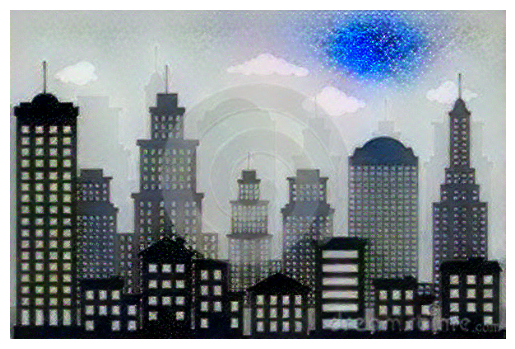

In [32]:
def im_convert(tensor):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    image = image + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    image = image.clamp(0, 1)
    return image.permute(1, 2, 0).numpy()


plt.imshow(im_convert(generated))
plt.axis('off')
plt.show()
